In [1]:
%matplotlib inline
from data_loading import Embeddings, load_sim_dataset, load_analogy_dataset
from clustering import cluster_words, print_cluster_words
import numpy as np
from scipy.stats import pearsonr, spearmanr
import matplotlib.pyplot as plt

# Evaluating Word Representations

## Word similarity

We will examine the use of word embeddings as representations for the meaning of words. In particular, we will use pretrained word embeddings as obtained in [1]: Dependency based embeddings and bag-of-words embeddings with k = 2 and 5.

In [2]:
# Load word embeddings
bow2embeddings = Embeddings("data/bow2.words")
bow5embeddings = Embeddings("data/bow5.words")
depembeddings = Embeddings("data/deps.words")
embedding_dict = {'BOW2': bow2embeddings, 'BOW5': bow5embeddings, 'Dependency': depembeddings}

# Load similarity datasets
simlex_pairs, simlex_scores = load_sim_dataset("data/SimLex-999.txt", score_col=3, skip=1)
men_pairs, men_scores = load_sim_dataset("data/MEN_dataset_natural_form_full", score_col=2)

### Qualitative results
We can evaluate the word embeddings quantitatively by getting a list of words similar to a given one when using each set of word embeddings.

In [10]:
test_words = ['batman', 'hogwarts', 'turing', 'florida', 'object-oriented', 'dancing']
for emb in embedding_dict:
    print(emb)
    for word in test_words:
        print('\t', word, ':', embedding_dict[emb].top_similar(word))

BOW2
	 batman : ['superman', 'superboy', 'aquaman', 'catwoman', 'batgirl']
	 hogwarts : ['evernight', 'sunnydale', 'garderobe', 'blandings', 'collinwood']
	 turing : ['non-deterministic', 'finite-state', 'nondeterministic', 'bchi', 'primality']
	 florida : ['fla', 'alabama', 'gainesville', 'tallahassee', 'texas']
	 object-oriented : ['aspect-oriented', 'event-driven', 'objective-c', 'dataflow', '4gl']
	 dancing : ['singing', 'dance', 'dances', 'breakdancing', 'clowning']
BOW5
	 batman : ['superman', 'catwoman', 'nightwing', 'spider-man', 'superboy']
	 hogwarts : ['dumbledore', 'dementors', 'hagrid', 'snape', 'voldemort']
	 turing : ['non-deterministic', 'nondeterministic', 'deterministic', 'finite-state', 'reducibility']
	 florida : ['jacksonville', 'tallahassee', 'miami', 'gainesville', 'sarasota']
	 object-oriented : ['aspect-oriented', 'event-driven', 'smalltalk', 'prolog', 'domain-specific']
	 dancing : ['singing', 'dance', 'dances', 'dancers', 'danced']
Dependency
	 batman : ['sup

We can see that in general, the word embeddings can capture the notion of similarity and relatedness because retrieving close vectors in the space yields semantically similar words.

We observe similar results between the BOW2 and Dependency embeddings, compared to the results obtained with the BOW5 embeddings. We hypothesize that this similarity should be expected since the BOW2 embeddings were built using a window of short size that would emphasize representations that take into account syntax, which is a crucial aspect for the Dependency embeddings. Therefore, we expect words close to each other in the space to be similar in the way they behave. The BOW5 embeddings, on the other hand, are built using a longer window which allows the embeddings to include topical information, so that we expect that embeddings close in the space are similar in terms of the context or topics in which they appear.

An interesting example that supports this result is the list of words similar to *hogwarts*. For the BOW2 and Dependency embeddings we find words functionally similar, like *sunnydale* and *collinwood*, whereas with the BOW5 embeddings we find words that appear in the same context, as *dumbledore*, *dementors* and *snape*.

### Quantitative results

In order to quantify the previous observation, we tested the word embeddings in tasks of similarity and relatedness, for which we used the SimLex and MEN datasets, respectively. By taking pairs of words, we use the cosine between the word embeddings as a score for the pair. We then evaluate the Pearson and Spearman correlations between these scores and the scores from the datasets.

In [51]:
def score_pairs(pairs, scores, embs, label):
    gold_scores = []
    sim_scores = []
    for i, (word1, word2) in enumerate(pairs):
        if word1 in embs.word2idx and word2 in embs.word2idx:
            # Get score from gold standard
            gold_scores.append(scores[i])
            
            # Calculate cosine similarity
            sim_scores.append(embs.similarity(word1, word2))
            
    # Get pearson and spearman correlation
    pearson_coeff = pearsonr(gold_scores, sim_scores)[0]
    spearman_coeff = spearmanr(gold_scores, sim_scores).correlation
    
    print('{:>10} {:^8.4f}  {:^8.4f}'.format(label, pearson_coeff, spearman_coeff))

print('{:10} {:^8s}  {:^8s}'.format('', 'Pearson', 'Spearman'))
for emb_name in embedding_dict:
    print('{:s}'.format(emb_name))    
    score_pairs(simlex_pairs, simlex_scores, embedding_dict[emb_name], 'SimLex')    
    score_pairs(men_pairs, men_scores, embedding_dict[emb_name], 'MEN')

           Pearson   Spearman
BOW2
    SimLex  0.4285    0.4141 
       MEN  0.6777    0.6999 
BOW5
    SimLex  0.3756    0.3674 
       MEN  0.7082    0.7232 
Dependency
    SimLex  0.4619    0.4456 
       MEN  0.5974    0.6178 


The results show that according to both coefficients, the Dependency based embeddings have a higher correlation on the similarity task, followed by the BOW2 embeddings. We argue that the BOW2 performs well due to its emphasis on syntax via shorter windows. This emphasis is improved by the Dependency embeddings as they are explicitly designed to capture syntactic similarity. For the relatedness task, topical information seems to be more important, with the BOW embeddings having higher correlations than the Dependency embeddings. In particular, the BOW5 embeddings score the highest correlations due to the use of a longer window that prioritizes topicality.

## Word Analogy

We now examine the usage of word embeddings to solve questions of the form "**a** is to **b** as **c** is to **?**". If $a$, $b$ and $c$ are the normalized word embeddings, we find the answer to the question by ranking all words using their distance to the result of the operation $b - a + c$ via the cosine similarity. As suggested in [2] we discarded the words in the question when searching for the answer, otherwise they would often appear as the closest result, possibly due to some compositional semantics captured by the operation.

### Qualitative results

We first explored this task by answering some test questions:

* man is to king as woman is to?
* day is to night as white is to?
* jump is to jumping as sing is to?
* word is to sentence as sentence is to?

In [80]:
test_questions = (('man', 'king', 'woman'), ('day', 'night', 'white'), ('jump', 'jumping', 'sing'), ('words', 'sentence', 'sentence'))
for question in test_questions:
    print("{:s} is to {:s} as {:s} is to...".format(question[0], question[1], question[2]))
    for emb_name, embeddings in embedding_dict.items():
        # Solve question using embeddings
        answers = embeddings.analogy(question[0], question[1], question[2])
        # Print top ranked answer
        print("\t{:s}: {:s}".format(emb_name, answers[0]))

man is to king as woman is to...
	BOW2: queen
	BOW5: queen
	Deps: queen
day is to night as white is to...
	BOW2: black
	BOW5: black
	Deps: black
jump is to jumping as sing is to...
	BOW2: singing
	BOW5: singing
	Deps: singing
words is to sentence as sentence is to...
	BOW2: sentences
	BOW5: paragraph
	Deps: sentences


We noted that the word embeddings could be used to solve a wide variety of questions involving gender, antonyms, grammar and even hierarchical structures, as in the last question. All embeddings give the same results, except for the last question in which we consider that *paragraph* is a better answer. With this in mind we hypothesize that in average, using the BOW5 embeddings gives better results for the analogy task due to their better representation of relatedness.

### Quantitative results

We obtained quantitative results for the analogy task using the [Google Word Analogy dataset](https://aclweb.org/aclwiki/Google_analogy_test_set_(State_of_the_art). For each question in the dataset.or each question in the dataset we evaluated the accuracy and Mean Reciprocal Rank (MRR). The MRR is calculated using the ranked answers to the analogy task according to their cosine similarity. 

Since this step requires calculating the cosine similarity for all the words, for all questions, the next cell took about 5 hours to complete with our setup.

In [4]:
analogies = load_analogy_dataset('data/questions-words.txt')

def get_analogy_stats(embs, analogies):
    count = 0
    correct = 0
    acc_rank = 0
    for i, (a, b, c, d) in enumerate(analogies):
        # Check first if we have embeddings for all words
        if all (word in embs.word2idx for word in (a, b, c)):
            count += 1
            # Get analogy results
            results = embs.analogy(a, b, c)

            # Update accuracy
            if results[0] == d:
                correct += 1

            # Update MRR
            try:            
                rank = results.index(d) + 1            
                acc_rank += 1/rank          
            except ValueError:
                # If word was not ranked, give rank score = 0
                continue
        
        # Print progress and stats so far
        if (count%1000) == 0:
            accuracy = int(100 * correct/count)
            mrr = int(100 * acc_rank/count)
            print('{:d}/{:d} acc: {:d} mrr: {:d}'.format(count, len(analogies), accuracy, mrr))

    accuracy = int(100 * correct/count)
    mrr = int(100 * acc_rank/count)
    print('acc: {:d} mrr: {:d}'.format(accuracy, mrr))

for emb_name in embedding_dict:
    print('{:s}'.format(emb_name))
    get_analogy_stats(embedding_dict[emb_name], analogies)

BOW2
1000/19544 acc: 71 mrr: 78
2000/19544 acc: 68 mrr: 76
3000/19544 acc: 67 mrr: 75
4000/19544 acc: 67 mrr: 75
5000/19544 acc: 65 mrr: 73
6000/19544 acc: 57 mrr: 65
7000/19544 acc: 54 mrr: 62
8000/19544 acc: 52 mrr: 60
9000/19544 acc: 52 mrr: 61
10000/19544 acc: 49 mrr: 58
11000/19544 acc: 50 mrr: 58
12000/19544 acc: 53 mrr: 61
13000/19544 acc: 54 mrr: 62
14000/19544 acc: 54 mrr: 62
15000/19544 acc: 55 mrr: 64
16000/19544 acc: 56 mrr: 64
17000/19544 acc: 56 mrr: 64
18000/19544 acc: 57 mrr: 65
19000/19544 acc: 58 mrr: 66
acc: 58 mrr: 66
BOW5
1000/19544 acc: 82 mrr: 87
2000/19544 acc: 77 mrr: 84
3000/19544 acc: 75 mrr: 83
4000/19544 acc: 73 mrr: 82
5000/19544 acc: 72 mrr: 81
6000/19544 acc: 64 mrr: 73
7000/19544 acc: 62 mrr: 70
8000/19544 acc: 60 mrr: 69
9000/19544 acc: 60 mrr: 69
10000/19544 acc: 56 mrr: 65
11000/19544 acc: 56 mrr: 65
12000/19544 acc: 58 mrr: 67
13000/19544 acc: 58 mrr: 67
14000/19544 acc: 59 mrr: 68
15000/19544 acc: 60 mrr: 69
16000/19544 acc: 61 mrr: 69
17000/19544 

The results are summarized in the following table:

|Model|Accuracy   |MRR      |
|-----|-----------|---------|
|BOW2 |0.58       |0.66     |
|BOW5 |**0.61**   |**0.70** |
|Deps |0.36       |0.44     |

These results confirm our hypothesis of the BOW5 model performing better due to the topical information obtained through a larger window, which is useful when solving analogies. The BOW2 and Deps models focus more on syntax, therefore their performance is lower. Of all the models, the Dependency model is the worst, because it is by design explicitly focusing on syntax. Additionally, we note that it is important to consider metrics for ranks such as the MRR as the accuracy alone can underestimate the performance of the model when it does not produce an exact match.

## Clustering Word Vectors

We can use dimensionality reduction techniques to visualize the word embeddings in two dimensions. In particular, we used Principal Component Analysis to project the embeddings from their initial space of dimensionality 300 down to a two dimensional space so that they can be easily visualized. The following experiments consider a small subset of distinguishable words for ease of interpretation.

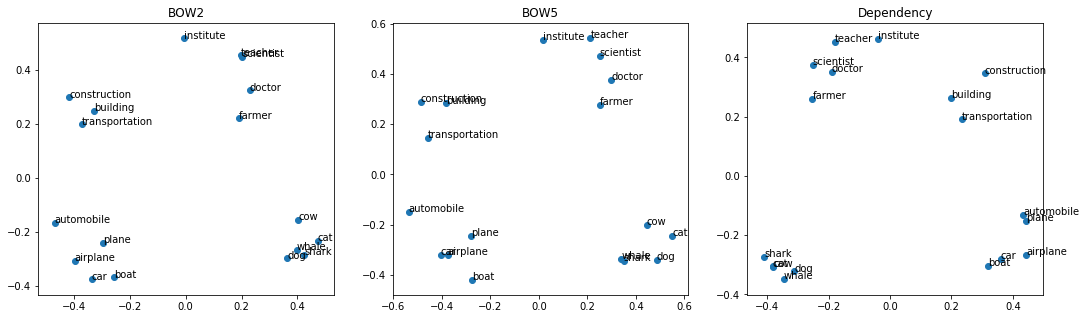

In [48]:
from sklearn.decomposition import PCA

def pca_from_words(file_path):
    # Load subset of test words
    with open(file_path) as file:
        words = [line.strip() for line in file]

    plt.figure(figsize=(18,5))
    plt.tight_layout()
    for i, (emb_name, embeddings) in enumerate(embedding_dict.items()):
        # Get embeddings
        test_embs = np.array([embeddings.vectors[embeddings.word2idx[word]] for word in words])
        # Project onto a two-dimensional space
        pca = PCA(n_components=2)
        reduced_embs = pca.fit_transform(test_embs)
        plt.subplot(1, 3, i+1)
        plt.scatter(reduced_embs[:, 0], reduced_embs[:, 1])
        plt.title(emb_name)
        for i, word in enumerate(words):
            plt.annotate(word, (reduced_embs[i, 0], reduced_embs[i, 1]))

pca_from_words('test-words.txt')

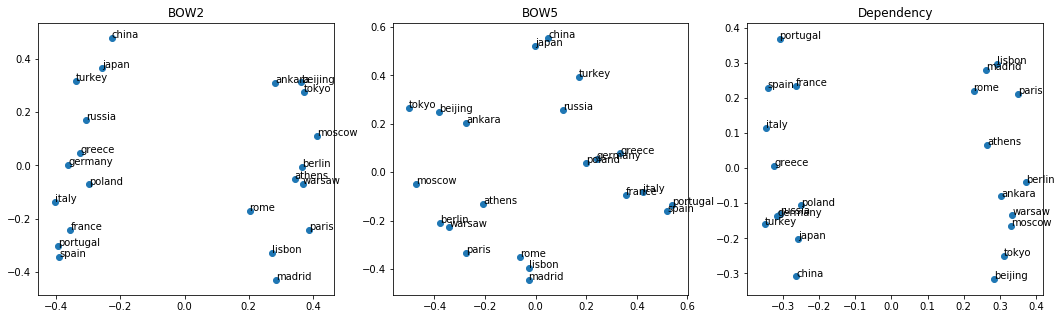

In [47]:
pca_from_words('test-words2.txt')

We now cluster a list of 2000 nouns by apply K-means clustering using each of the three word embedding models. We experiment with 5 different cluster sizes = {10,25,50,100,200} and analyze the qualitative properties of the clustered words for each of the three word embedding models.

In [3]:
frequent_nouns = []
with open('data/2000_nouns_sorted.txt','r') as f:
    for line in f:
        for word in line.split():
            if word != 'fig.':
                frequent_nouns.append(word)
        
num_clusters=10        
frequent_embeddings, bow2_labels, bow5_labels, dep_labels = cluster_words(embedding_dict, frequent_nouns, num_clusters)

print("Number of clusters = {}".format(num_clusters))
cluster_num = np.random.randint(1, num_clusters)

print("Words clusterd with bow2 embeddings in cluster {}: ".format(cluster_num))
print_cluster_words(cluster_num, frequent_nouns, bow2_labels)
        
print("Words clusterd with bow5 embeddings in cluster {}: ".format(cluster_num))        
print_cluster_words(cluster_num, frequent_nouns, bow5_labels)

print("Words clusterd with dep embeddings in cluster {}: ".format(cluster_num))        
print_cluster_words(cluster_num, frequent_nouns, dep_labels) 

Number of clusters = 10
Words clusterd with bow2 embeddings in cluster 7: 
['ability', 'absence', 'abuse', 'acceptance', 'accuracy', 'alarm', 'ambition', 'anger', 'anxiety', 'atmosphere', 'attention']
Words clusterd with bow5 embeddings in cluster 7: 
['ability', 'absence', 'abuse', 'acceptance', 'accuracy', 'achievement', 'activity', 'adoption', 'advantage', 'ambition', 'anger']
Words clusterd with dep embeddings in cluster 7: 
['ability', 'achievement', 'agenda', 'alarm', 'allegation', 'ambition', 'anger', 'anxiety', 'argument', 'aspect', 'assumption']


In [5]:
num_clusters=25
frequent_embeddings, bow2_labels, bow5_labels, dep_labels = cluster_words(embedding_dict, frequent_nouns, num_clusters)

print("Number of clusters = {}".format(num_clusters))
cluster_num = np.random.randint(1, num_clusters)

print("Words clusterd with bow2 embeddings in cluster {}: ".format(cluster_num))
print_cluster_words(cluster_num, frequent_nouns, bow2_labels)
        
print("Words clusterd with bow5 embeddings in cluster {}: ".format(cluster_num))        
print_cluster_words(cluster_num, frequent_nouns, bow5_labels)

print("Words clusterd with dep embeddings in cluster {}: ".format(cluster_num))        
print_cluster_words(cluster_num, frequent_nouns, dep_labels)

visual_embeddings = frequent_embeddings
v_bow2_labels = bow2_labels 
v_bow5_labels = bow5_labels 
v_dep_labels = dep_labels

Number of clusters = 25
Words clusterd with bow2 embeddings in cluster 5: 
['admission', 'agreement', 'amendment', 'appeal', 'applicant', 'appointment', 'approval', 'arrest', 'certificate', 'charter', 'clause']
Words clusterd with bow5 embeddings in cluster 5: 
['adviser', 'ambassador', 'appointment', 'assembly', 'assistant', 'auditor', 'bishop', 'board', 'cabinet', 'candidate', 'chair']
Words clusterd with dep embeddings in cluster 5: 
['ability', 'accuracy', 'achievement', 'advantage', 'attention', 'capability', 'capacity', 'complexity', 'concentration', 'content', 'contents']


In [6]:
num_clusters=50
frequent_embeddings, bow2_labels, bow5_labels, dep_labels = cluster_words(embedding_dict, frequent_nouns, num_clusters)

print("Number of clusters = {}".format(num_clusters))
cluster_num = np.random.randint(1, num_clusters)

print("Words clusterd with bow2 embeddings in cluster {}: ".format(cluster_num))
print_cluster_words(cluster_num, frequent_nouns, bow2_labels)
        
print("Words clusterd with bow5 embeddings in cluster {}: ".format(cluster_num))        
print_cluster_words(cluster_num, frequent_nouns, bow5_labels)

print("Words clusterd with dep embeddings in cluster {}: ".format(cluster_num))        
print_cluster_words(cluster_num, frequent_nouns, dep_labels)

Number of clusters = 50
Words clusterd with bow2 embeddings in cluster 31: 
['album', 'best', 'book', 'composition', 'copy', 'dance', 'diary', 'drawing', 'english', 'essay', 'guitar']
Words clusterd with bow5 embeddings in cluster 31: 
['access', 'amendment', 'applicant', 'authority', 'breach', 'charter', 'clause', 'compliance', 'concession', 'consent', 'consideration']
Words clusterd with dep embeddings in cluster 31: 
['architecture', 'bible', 'composition', 'culture', 'curriculum', 'democracy', 'design', 'discipline', 'discourse', 'doctrine', 'drama']


In [7]:
num_clusters=100
frequent_embeddings, bow2_labels, bow5_labels, dep_labels = cluster_words(embedding_dict, frequent_nouns, num_clusters)

print("Number of clusters = {}".format(num_clusters))
cluster_num = np.random.randint(1, num_clusters)

print("Words clusterd with bow2 embeddings in cluster {}: ".format(cluster_num))
print_cluster_words(cluster_num, frequent_nouns, bow2_labels)
        
print("Words clusterd with bow5 embeddings in cluster {}: ".format(cluster_num))        
print_cluster_words(cluster_num, frequent_nouns, bow5_labels)

print("Words clusterd with dep embeddings in cluster {}: ".format(cluster_num))        
print_cluster_words(cluster_num, frequent_nouns, dep_labels)

Number of clusters = 100
Words clusterd with bow2 embeddings in cluster 27: 
['ally', 'boss', 'brother', 'colleague', 'companion', 'cousin', 'fellow', 'friend', 'lover', 'neighbour', 'partner']
Words clusterd with bow5 embeddings in cluster 27: 
['acid', 'animal', 'bacterium', 'bird', 'body', 'cell', 'creature', 'entity', 'factor', 'fragment', 'gene']
Words clusterd with dep embeddings in cluster 27: 
['apple', 'arrow', 'ball', 'basket', 'blanket', 'boot', 'bottle', 'brush', 'bucket', 'bull', 'bullet']


In [9]:
num_clusters=200
frequent_embeddings, bow2_labels, bow5_labels, dep_labels = cluster_words(embedding_dict, frequent_nouns, num_clusters)

print("Number of clusters = {}".format(num_clusters))
cluster_num = np.random.randint(1, num_clusters)

print("Words clusterd with bow2 embeddings in cluster {}: ".format(cluster_num))
print_cluster_words(cluster_num, frequent_nouns, bow2_labels)
        
print("Words clusterd with bow5 embeddings in cluster {}: ".format(cluster_num))        
print_cluster_words(cluster_num, frequent_nouns, bow5_labels)

print("Words clusterd with dep embeddings in cluster {}: ".format(cluster_num))        
print_cluster_words(cluster_num, frequent_nouns, dep_labels)

Number of clusters = 200
Words clusterd with bow2 embeddings in cluster 117: 
['co-operation', 'communication', 'dialogue', 'exchange', 'friendship', 'partnership', 'peace', 'unity']
Words clusterd with bow5 embeddings in cluster 117: 
['anniversary', 'birthday', 'ceremony', 'event', 'occasion']
Words clusterd with dep embeddings in cluster 117: 
['colour', 'feeling', 'flavour', 'gaze', 'habit', 'mood', 'rhythm', 'scent', 'sight', 'smell', 'sound']


### References
[1] Levy, O., & Goldberg, Y. (2014). Dependency-based word embeddings. In Proceedings of the 52nd Annual Meeting of the Association for Computational Linguistics (Volume 2: Short Papers) (Vol. 2, pp. 302-308).

[2] Mikolov, T., Chen, K., Corrado, G., & Dean, J. (2013). Efficient estimation of word representations in vector space. arXiv preprint arXiv:1301.3781.